In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import sys
sys.path.insert(0, 'drive/Bitirme Tezi/2016.c/FullyConnectedNetwork')

In [ ]:
!pip install -q keras

In [ ]:
ls

adc.json  drive/  sample_data/


In [ ]:
cd drive/Bitirme Tezi/2016.c/FullyConnectedNetwork

/content/drive/Bitirme Tezi/2016.c/FullyConnectedNetwork


Import the libraries

In [ ]:
import os,random
import numpy as np
import pandas as pd
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras
import pickle
from keras.callbacks import ModelCheckpoint
import itertools

In [ ]:
#%% load dataset
dataSetLoad = pickle.load(open("2016.04C.multisnr.pkl", 'rb'), encoding='latin')
len(dataSetLoad.keys())        #number of keys
dataSetLoad['8PSK', -20]       #elements of this key
dataSetLoad['8PSK', -16].shape #shape of this key

(413, 2, 128)

In [ ]:
SNRs, modulation_types = map(lambda j: sorted(list(set(map(lambda x: x[j], dataSetLoad.keys())))), [1,0]) #SNRs and modulation types
dataSet   = []
data8PSK  = [] 
dataAMDSB = []
dataAMSSB = []
dataBPSK  = []
dataCPFSK = []
dataGFSK  = []
dataPAM4  = []
dataQAM16 = []
dataQAM64 = []
dataQPSK  = []
dataWBFM  = []
label = []
for mod in modulation_types:
    for snr in SNRs:
        if mod == '8PSK':
            data8PSK.append(dataSetLoad[(mod,snr)])
        if mod == 'AM-DSB':
            dataAMDSB.append(dataSetLoad[(mod,snr)])
        if mod == 'AM-SSB':
            dataAMSSB.append(dataSetLoad[(mod,snr)])
        if mod == 'BPSK':
            dataBPSK.append(dataSetLoad[(mod,snr)])
        if mod == 'CPFSK':
            dataCPFSK.append(dataSetLoad[(mod,snr)])
        if mod == 'GFSK':
            dataGFSK.append(dataSetLoad[(mod,snr)])
        if mod == 'PAM4':
            dataPAM4.append(dataSetLoad[(mod,snr)])
        if mod == 'QAM16':
            dataQAM16.append(dataSetLoad[(mod,snr)])
        if mod == 'QAM64':
            dataQAM64.append(dataSetLoad[(mod,snr)])
        if mod == 'QPSK':
            dataQPSK.append(dataSetLoad[(mod,snr)])
        if mod == 'WBFM':
            dataWBFM.append(dataSetLoad[(mod,snr)])
        
        dataSet.append(dataSetLoad[(mod,snr)])
        for i in range(dataSetLoad[(mod,snr)].shape[0]):  
            label.append((mod,snr))
            
dataSet = np.vstack(dataSet)
print(len(dataSet))

162060


In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
train_index   = []
np.random.seed(2020)
totalNumberSignals = dataSet.shape[0]
n_train = int(totalNumberSignals * 7 / 10)
train_index = np.random.choice(range(0,totalNumberSignals), size=n_train, replace=False)
random.shuffle(train_index) # suffling
test_index = list(set(range(0,totalNumberSignals))-set(train_index))

X_train = dataSet[train_index]
X_train = X_train.reshape(len(X_train),X_train[0].shape[0], X_train[0].shape[1], 1 )
X_test =  dataSet[test_index]
X_test = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], 1)

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+ 1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: modulation_types.index(label[x][0]), train_index)))
Y_test = to_onehot(list(map(lambda x: modulation_types.index(label[x][0]), test_index)))

in_shape = list(X_train.shape[1:])
print ("X_train shape", X_train.shape)
print ("X_test shape", X_test.shape)
print ("in shape", in_shape)



X_train shape (113442, 2, 128, 1)
X_test shape (48618, 2, 128, 1)
in shape [2, 128, 1]


In [ ]:
in_shape = list(X_train.shape[1:])
print ("X_train shape", X_train.shape)
print ("X_test shape", X_test.shape)
print ("Y_train shape", Y_train.shape)
print ("Y_test shape", Y_test.shape)
print ("in shape", in_shape)

X_train = X_train.reshape(-1, 2*128)
X_test = X_test.reshape(-1, 2*128)


X_train shape (113442, 2, 128, 1)
X_test shape (48618, 2, 128, 1)
Y_train shape (113442, 11)
Y_test shape (48618, 11)
in shape [2, 128, 1]


In [ ]:
def get_model():
  # %% CNN Model Tanımlama
  model = Sequential()
  # 1. KATMAN
  model.add(Dense(1024,activation='relu',input_shape=(2*128, )))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # 2. KATMAN
  model.add(Dense(1024,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # 3. KATMAN
  model.add(Dense(512,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # 4. KATMAN
  model.add(Dense(128,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  # çıkış katmanı
  model.add(Dense(len(modulation_types),activation='softmax' ))
  model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'] )#optimizasyon ve başarım hesaplama metriklerinin belirlenmesi
  model.summary()
  return model

In [ ]:
model1 = get_model()
model2 = get_model()
model3 = get_model()
model4 = get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

In [ ]:
# %% Eğitim ve ağırlıkların .h5 uzantılı dosya şeklinde kaydedilmesi
# en başarılı ağırlıkları kaydet
batchsize1 = 64
batchsize2 = 128
batchsize3 = 512
batchsize4 = 1024
def train_model(batch_size_, model):
    epochs = 100
    # perform training ...
    #   - call the main training loop in keras for our network+dataset
    filepath = 'modulation_model.h5'
    history = model.fit(X_train,
        Y_train,
        batch_size=batch_size_,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, Y_test),
            callbacks = [
            keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),

            ])
    model.load_weights(filepath)
    return model, history 


In [ ]:
print('model1 is training')
trained_model1, history1 = train_model(batchsize1, model1)
print('model2 is training')
trained_model2, history2 = train_model(batchsize2, model2)
print('model3 is training')
trained_model3, history3 = train_model(batchsize3, model3)
print('model4 is training')
trained_model4, history4 = train_model(batchsize4, model4)

model1 is training
Epoch 1/100
1773/1773 [==============================] - 14s 6ms/step - loss: 2.5841 - accuracy: 0.1843 - val_loss: 1.8337 - val_accuracy: 0.3072

Epoch 00001: val_loss improved from inf to 1.83369, saving model to modulation_model.h5
Epoch 2/100
1773/1773 [==============================] - 9s 5ms/step - loss: 1.7514 - accuracy: 0.3358 - val_loss: 1.5345 - val_accuracy: 0.4134

Epoch 00002: val_loss improved from 1.83369 to 1.53449, saving model to modulation_model.h5
Epoch 3/100
1773/1773 [==============================] - 9s 5ms/step - loss: 1.5007 - accuracy: 0.4252 - val_loss: 1.3992 - val_accuracy: 0.4637

Epoch 00003: val_loss improved from 1.53449 to 1.39920, saving model to modulation_model.h5
Epoch 4/100
1773/1773 [==============================] - 8s 5ms/step - loss: 1.4180 - accuracy: 0.4532 - val_loss: 1.3899 - val_accuracy: 0.4811

Epoch 00004: val_loss improved from 1.39920 to 1.38987, saving model to modulation_model.h5
Epoch 5/100
1773/1773 [=========

In [ ]:
# Show simple version of performance
train_loss, train_acc  = trained_model1.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 64', train_loss)
print('train_acc- batch size = 64', train_acc)
test_loss, test_acc  = trained_model1.evaluate(X_test, Y_test, verbose = 1)
print('test loss- batch size = 64', test_loss)
print('test accuracy- batch size = 64', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model2.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 128', train_loss)
print('train_acc - batch size = 128', train_acc)
test_loss, test_acc  = trained_model2.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 128', test_loss)
print('test accuracy - batch size = 128', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model3.evaluate(X_train, Y_train, verbose = 1)
print('train_loss - batch size = 512', train_loss)
print('train_acc - batch size = 512', train_acc)
test_loss, test_acc  = trained_model3.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 512', test_loss)
print('test accuracy - batch size = 512', test_acc)

# Show simple version of performance
train_loss, train_acc  = trained_model4.evaluate(X_train, Y_train, verbose = 1)
print('train_loss  - batch size = 1024', train_loss)
print('train_acc  - batch size = 1024 ', train_acc)
test_loss, test_acc  = trained_model4.evaluate(X_test, Y_test, verbose = 1)
print('test loss - batch size = 1024 ', test_loss)
print('test accuracy  - batch size = 1024 ', test_acc)


3546/3546 [==============================] - 7s 2ms/step - loss: 1.0874 - accuracy: 0.6008
train_loss - batch size = 64 1.0873749256134033
train_acc- batch size = 64 0.6008180379867554
1520/1520 [==============================] - 3s 2ms/step - loss: 1.1700 - accuracy: 0.5652
test loss- batch size = 64 1.1699857711791992
test accuracy- batch size = 64 0.5652021765708923
3546/3546 [==============================] - 7s 2ms/step - loss: 0.8625 - accuracy: 0.6793
train_loss - batch size = 128 0.8624535799026489
train_acc - batch size = 128 0.6792634129524231
1520/1520 [==============================] - 3s 2ms/step - loss: 0.9784 - accuracy: 0.6255
test loss - batch size = 128 0.9784456491470337
test accuracy - batch size = 128 0.6254885196685791
3546/3546 [==============================] - 7s 2ms/step - loss: 0.7662 - accuracy: 0.7061
train_loss - batch size = 512 0.7662019729614258
train_acc - batch size = 512 0.7060612440109253
1520/1520 [==============================] - 3s 2ms/step - lo

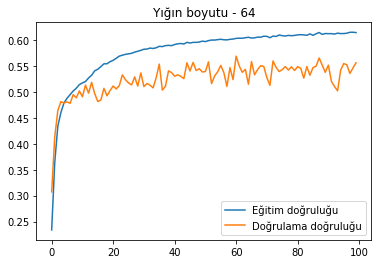

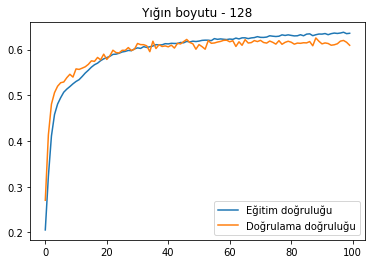

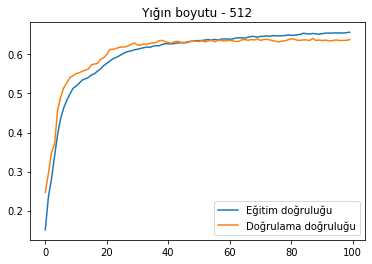

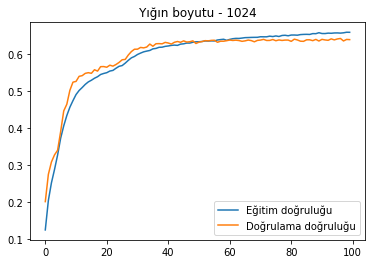

In [ ]:
plt.figure(1)
plt.title('Yığın boyutu - 64')
plt.plot(history1.epoch, history1.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history1.epoch, history1.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(2)
plt.title('Yığın boyutu - 128')
plt.plot(history2.epoch, history2.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history2.epoch, history2.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(3)
plt.title('Yığın boyutu - 512')
plt.plot(history3.epoch, history3.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history3.epoch, history3.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

plt.figure(4)
plt.title('Yığın boyutu - 1024')
plt.plot(history4.epoch, history4.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history4.epoch, history4.history['val_accuracy'], label='Doğrulama doğruluğu')
plt.legend()

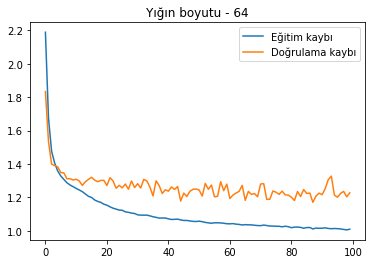

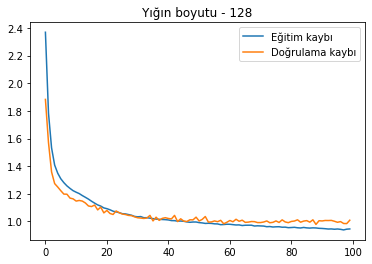

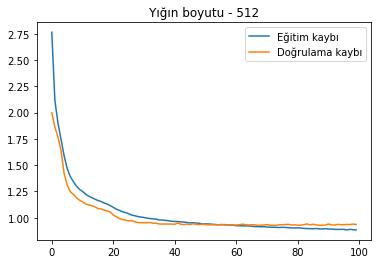

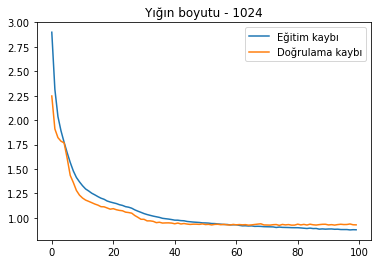

In [ ]:
# Show loss curves 
plt.figure(5)
plt.title('Yığın boyutu - 64')
plt.plot(history1.epoch, history1.history['loss'], label='Eğitim kaybı')
plt.plot(history1.epoch, history1.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

# Show loss curves 
plt.figure(6)
plt.title('Yığın boyutu - 128')
plt.plot(history2.epoch, history2.history['loss'], label='Eğitim kaybı')
plt.plot(history2.epoch, history2.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

plt.figure(7)
plt.title('Yığın boyutu - 512')
plt.plot(history3.epoch, history3.history['loss'], label='Eğitim kaybı')
plt.plot(history3.epoch, history3.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

plt.figure(8)
plt.title('Yığın boyutu - 1024')
plt.plot(history4.epoch, history4.history['loss'], label='Eğitim kaybı')
plt.plot(history4.epoch, history4.history['val_loss'], label='Doğrulama kaybı')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='FCNN', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize = 12)
    plt.yticks(tick_marks, labels, fontsize = 12)
    plt.tight_layout()
    plt.ylabel('Gerçek sınıf', fontsize = 12 )
    plt.xlabel('Tahmin edilen sınıf', fontsize = 12)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                  fontsize=12,
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

In [ ]:
# Plot confusion matrix
def plot_cm_to_batchsize(model, batchsize_):
  test_Y_hat = model.predict(X_test, batch_size=batchsize_)
  conf = np.zeros([len(modulation_types),len(modulation_types)])
  confnorm = np.zeros([len(modulation_types),len(modulation_types)])
  for i in range(0,X_test.shape[0]):
      j = list(Y_test[i,:]).index(1)
      k = int(np.argmax(test_Y_hat[i,:]))
      conf[j,k] = conf[j,k] + 1
  for i in range(0,len(modulation_types)):
      confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
  plt.figure(3)
  plot_confusion_matrix(confnorm, labels=modulation_types)  

<Figure size 432x288 with 0 Axes>

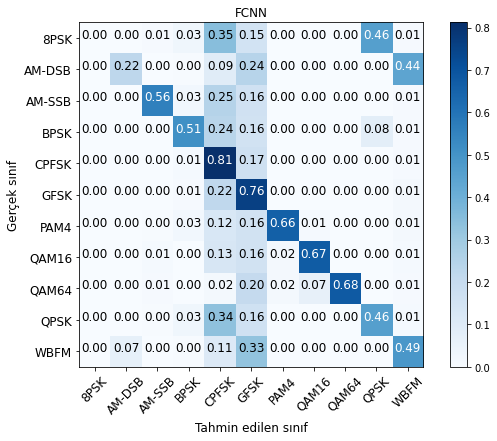

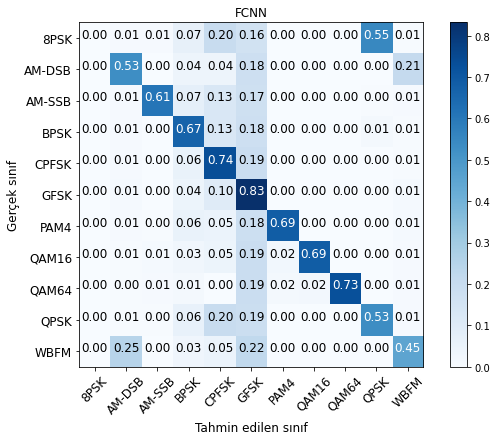

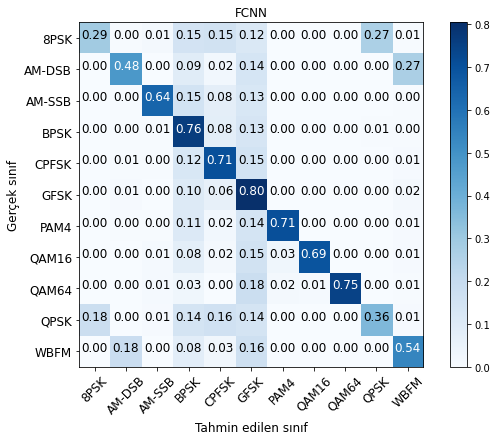

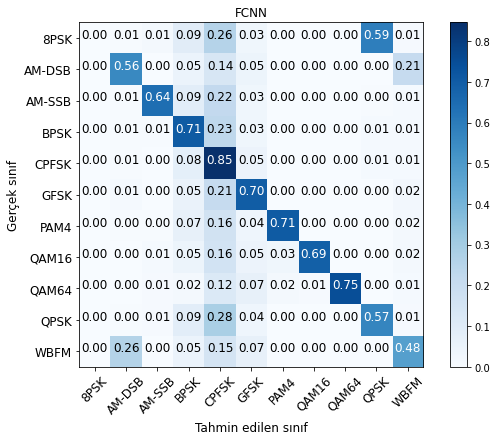

In [ ]:
plot_cm_to_batchsize(trained_model1, batchsize1)
plot_cm_to_batchsize(trained_model2, batchsize2)
plot_cm_to_batchsize(trained_model3, batchsize3)
plot_cm_to_batchsize(trained_model4, batchsize4)

In [ ]:
# Plot confusion matrix
def plot_cm_snr(model, batch_size):
  acc = {}
  for snr in SNRs:
      # extract modulation_types @ SNR
      test_SNRs = list(map(lambda x: label[x][1], test_index))
      test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
      test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

      # estimate modulation_types
      test_Y_i_hat = model.predict(test_X_i)
      conf = np.zeros([len(modulation_types),len(modulation_types)])
      confnorm = np.zeros([len(modulation_types),len(modulation_types)])
      for i in range(0,test_X_i.shape[0]):
          j = list(test_Y_i[i,:]).index(1)
          k = int(np.argmax(test_Y_i_hat[i,:]))
          conf[j,k] = conf[j,k] + 1
      for i in range(0,len(modulation_types)):
          confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
      plt.figure()
      plot_confusion_matrix(confnorm, labels=modulation_types, title="FCNN, SNR=%d dB, Yığın boyutu= %d"%(snr, batch_size))
      
      cor = np.sum(np.diag(conf))
      ncor = np.sum(conf) - cor
      print ("SNR : ", snr)
      print ("Overall Accuracy:", cor / (cor+ncor))
      acc[snr] = 1.0*cor/(cor+ncor)
  
  return acc

    




SNR :  -20
Overall Accuracy: 0.1401792991035045
SNR :  -18
Overall Accuracy: 0.14953271028037382
SNR :  -16
Overall Accuracy: 0.16358405260994657
SNR :  -14
Overall Accuracy: 0.17745136959110758
SNR :  -12
Overall Accuracy: 0.19527109661638808
SNR :  -10
Overall Accuracy: 0.25052279381012127
SNR :  -8
Overall Accuracy: 0.3971370143149284
SNR :  -6
Overall Accuracy: 0.48895253682487727
SNR :  -4
Overall Accuracy: 0.5604756047560475
SNR :  -2
Overall Accuracy: 0.7110655737704918


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


SNR :  0
Overall Accuracy: 0.7672697368421053
SNR :  2
Overall Accuracy: 0.8144853875476493
SNR :  4
Overall Accuracy: 0.7786592621975407
SNR :  6
Overall Accuracy: 0.8427518427518428
SNR :  8
Overall Accuracy: 0.7928571428571428
SNR :  10
Overall Accuracy: 0.7901543596161869
SNR :  12
Overall Accuracy: 0.802021903959562
SNR :  14
Overall Accuracy: 0.8426270136307311
SNR :  16
Overall Accuracy: 0.8070539419087137
SNR :  18
Overall Accuracy: 0.872969596001666
SNR :  -20
Overall Accuracy: 0.14425427872860636
SNR :  -18
Overall Accuracy: 0.152377082486794
SNR :  -16
Overall Accuracy: 0.1607069461570078
SNR :  -14
Overall Accuracy: 0.18062723302897976
SNR :  -12
Overall Accuracy: 0.21076233183856502
SNR :  -10
Overall Accuracy: 0.2944374738603095
SNR :  -8
Overall Accuracy: 0.4638036809815951
SNR :  -6
Overall Accuracy: 0.6031096563011457
SNR :  -4
Overall Accuracy: 0.6929069290692907
SNR :  -2
Overall Accuracy: 0.855327868852459
SNR :  0
Overall Accuracy: 0.8379934210526315
SNR :  2
Overa

<Figure size 432x288 with 0 Axes>

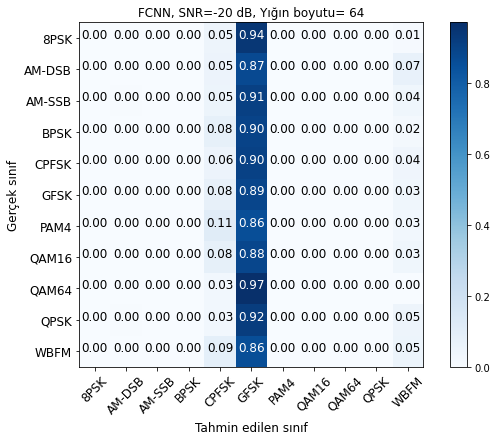

<Figure size 432x288 with 0 Axes>

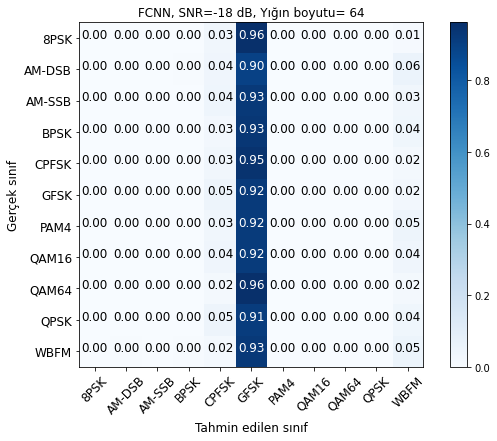

<Figure size 432x288 with 0 Axes>

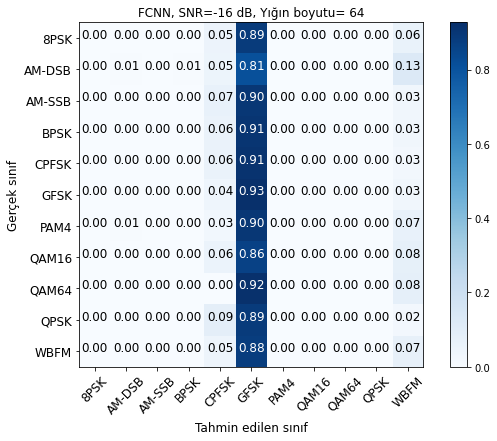

<Figure size 432x288 with 0 Axes>

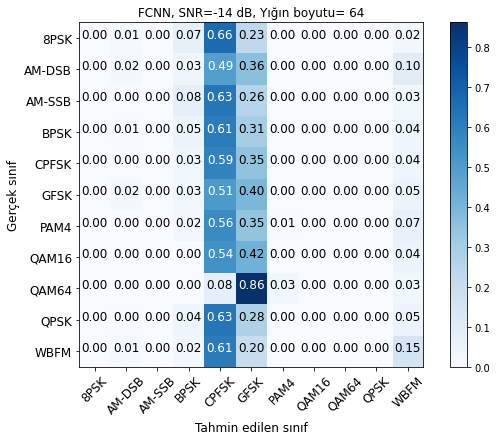

<Figure size 432x288 with 0 Axes>

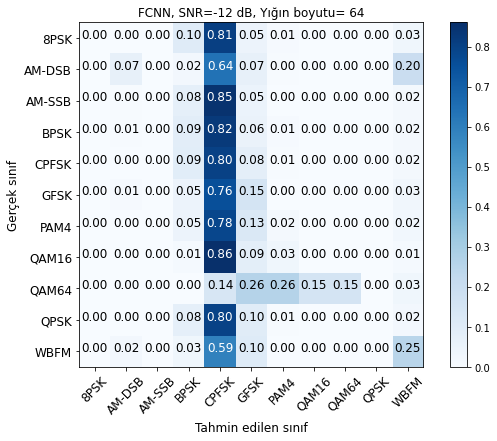

<Figure size 432x288 with 0 Axes>

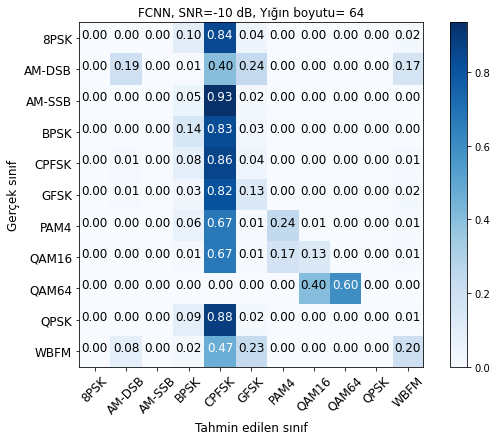

<Figure size 432x288 with 0 Axes>

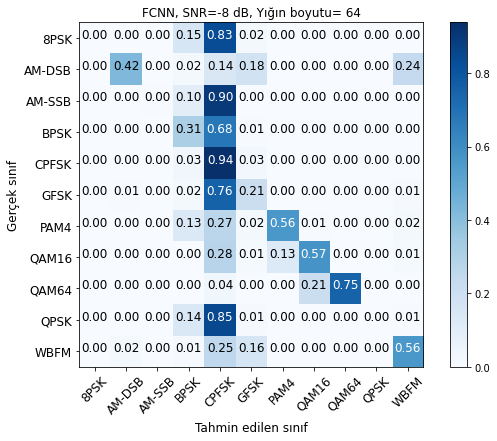

<Figure size 432x288 with 0 Axes>

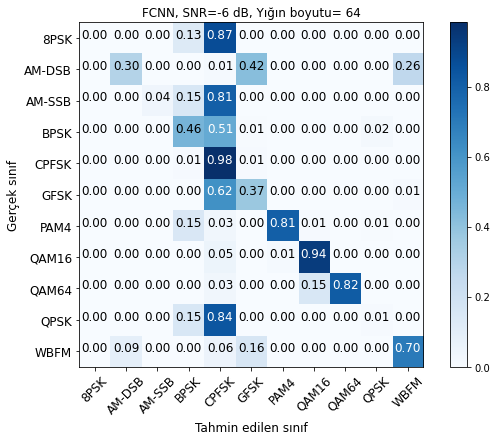

<Figure size 432x288 with 0 Axes>

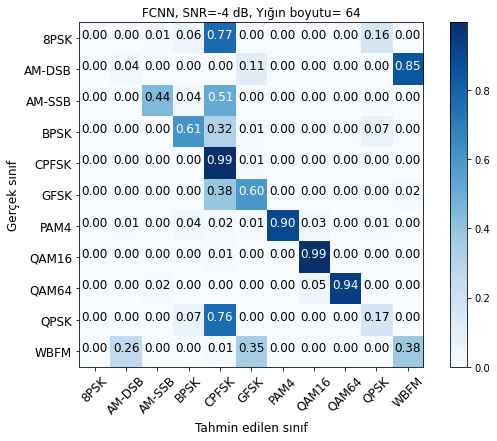

<Figure size 432x288 with 0 Axes>

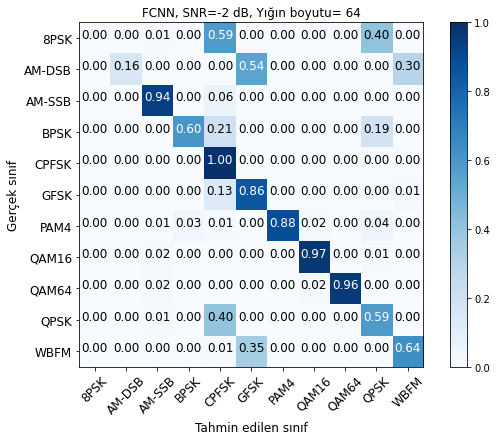

<Figure size 432x288 with 0 Axes>

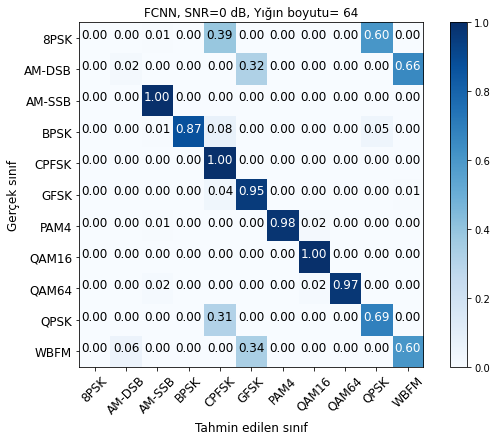

<Figure size 432x288 with 0 Axes>

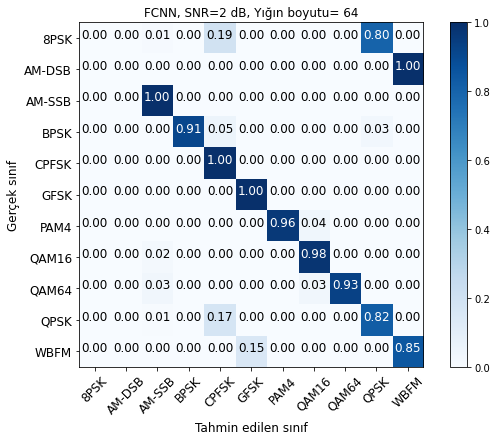

<Figure size 432x288 with 0 Axes>

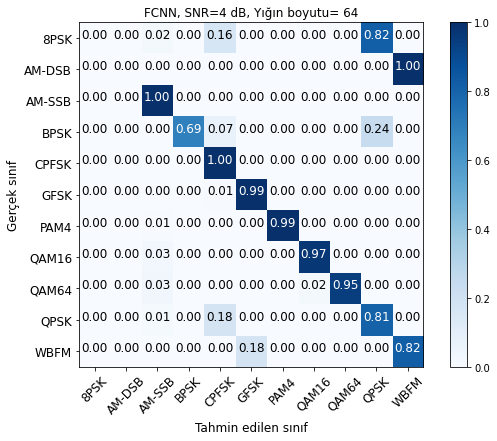

<Figure size 432x288 with 0 Axes>

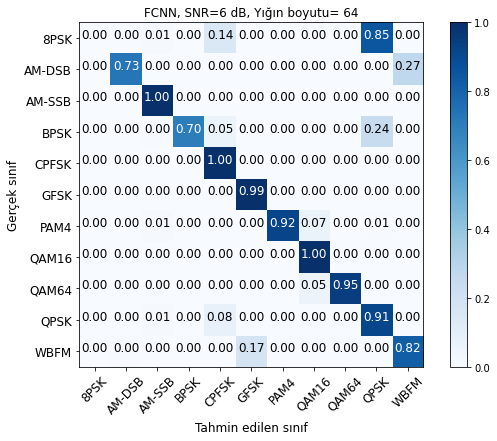

<Figure size 432x288 with 0 Axes>

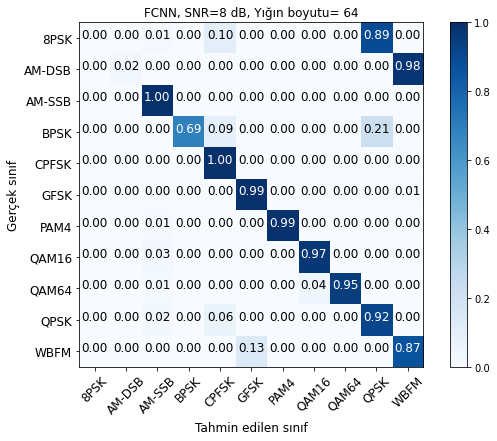

<Figure size 432x288 with 0 Axes>

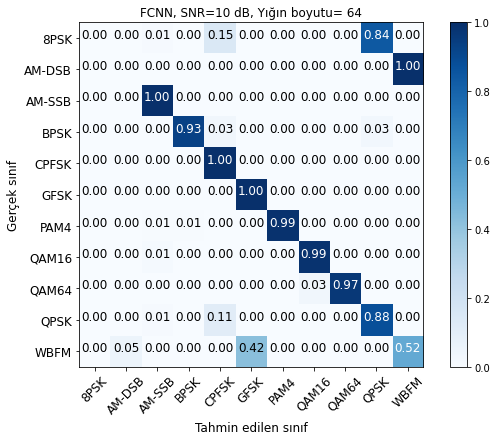

<Figure size 432x288 with 0 Axes>

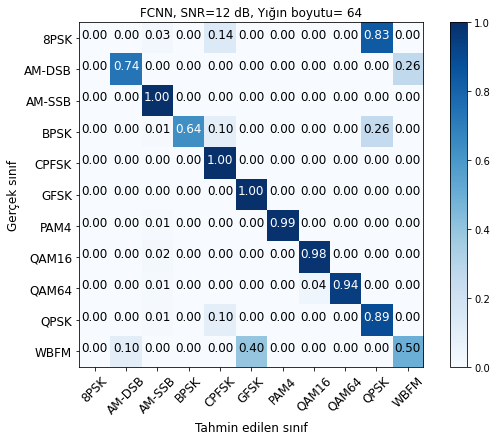

<Figure size 432x288 with 0 Axes>

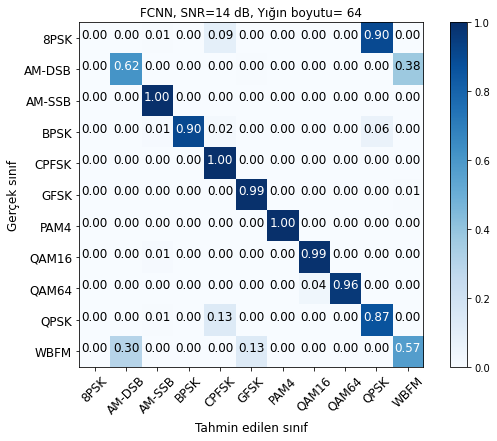

<Figure size 432x288 with 0 Axes>

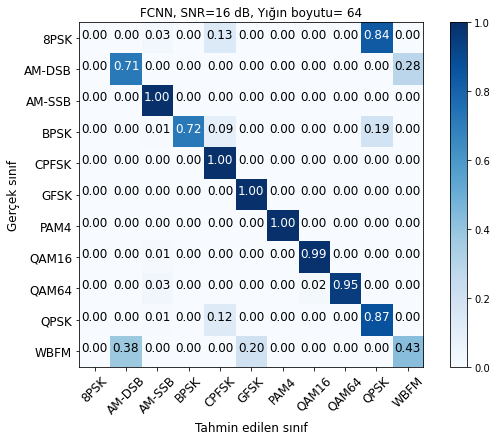

<Figure size 432x288 with 0 Axes>

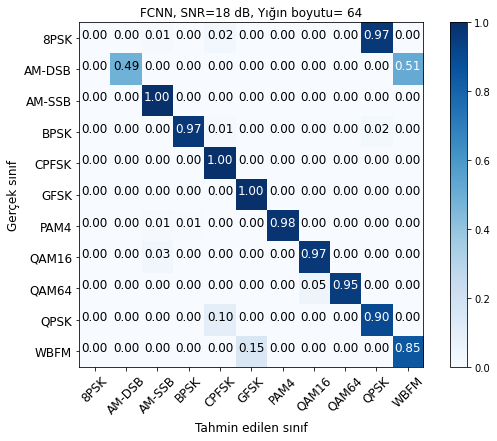

<Figure size 432x288 with 0 Axes>

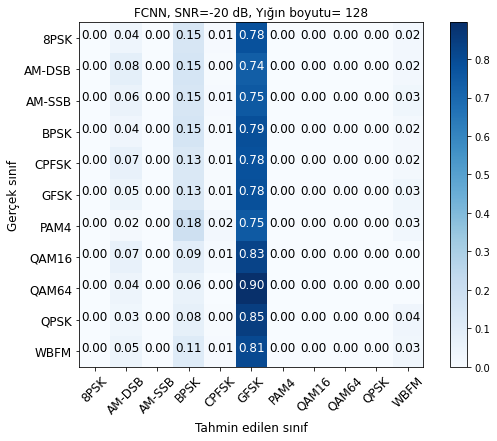

<Figure size 432x288 with 0 Axes>

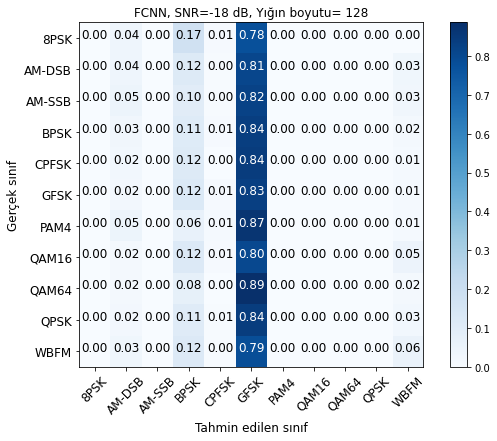

<Figure size 432x288 with 0 Axes>

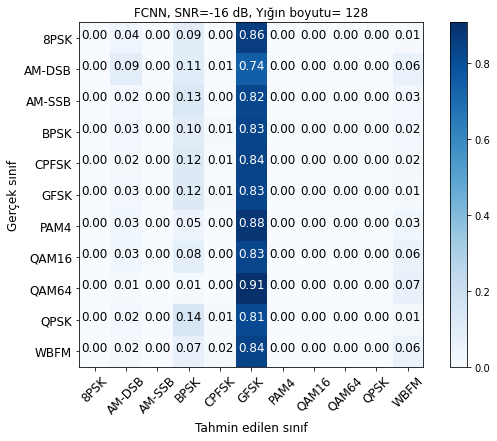

<Figure size 432x288 with 0 Axes>

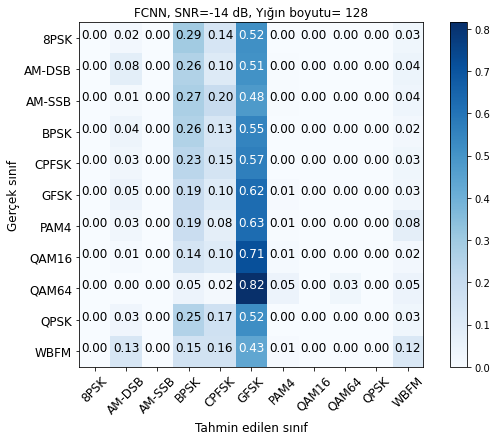

<Figure size 432x288 with 0 Axes>

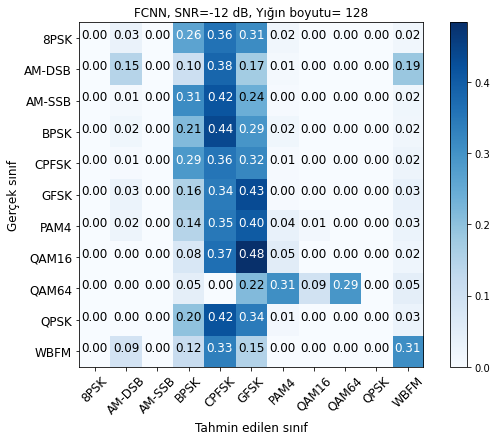

<Figure size 432x288 with 0 Axes>

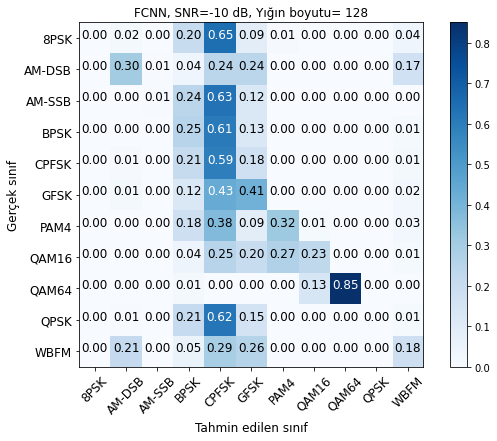

<Figure size 432x288 with 0 Axes>

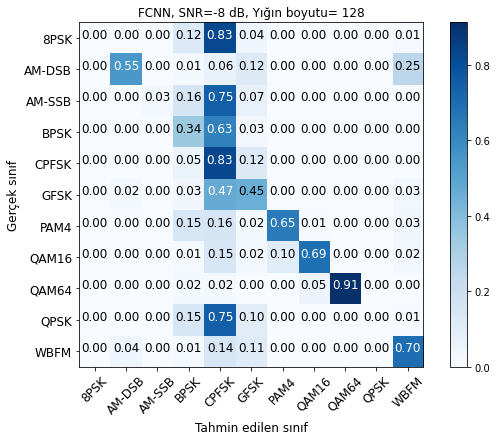

<Figure size 432x288 with 0 Axes>

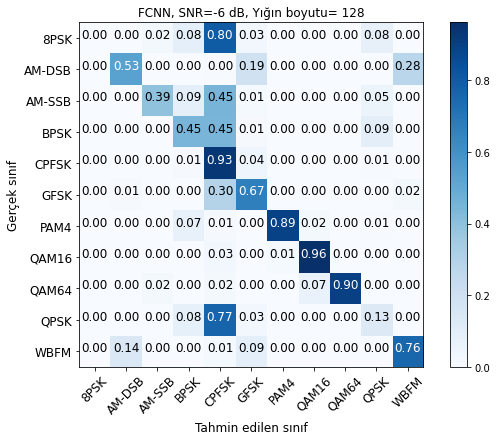

<Figure size 432x288 with 0 Axes>

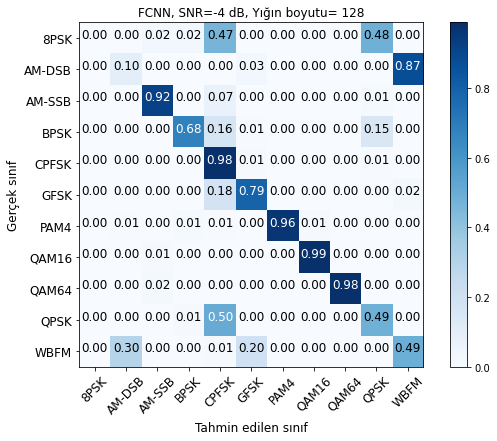

<Figure size 432x288 with 0 Axes>

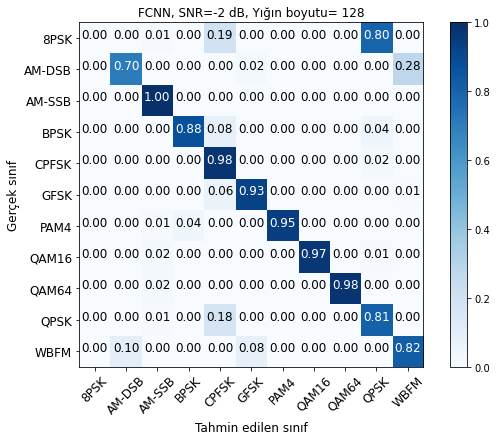

<Figure size 432x288 with 0 Axes>

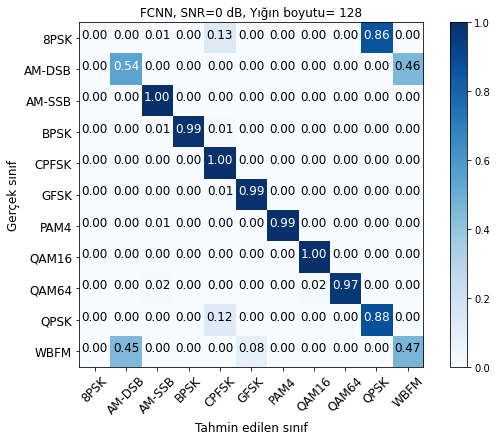

<Figure size 432x288 with 0 Axes>

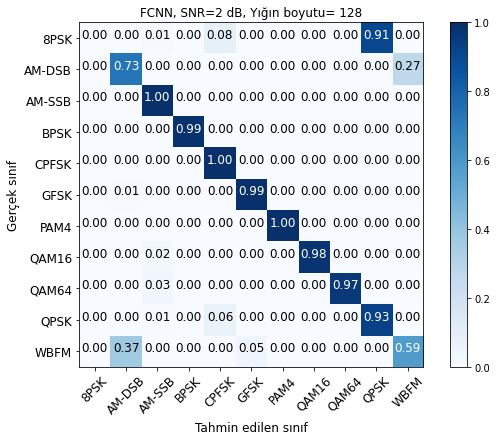

<Figure size 432x288 with 0 Axes>

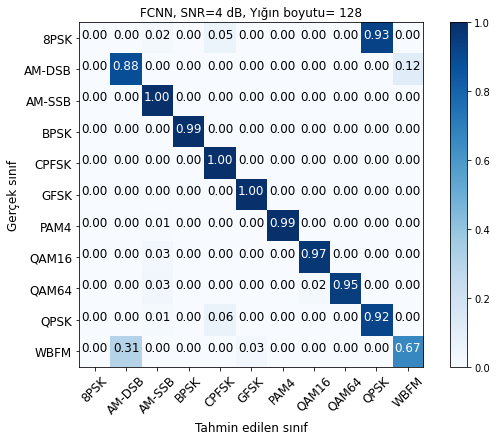

<Figure size 432x288 with 0 Axes>

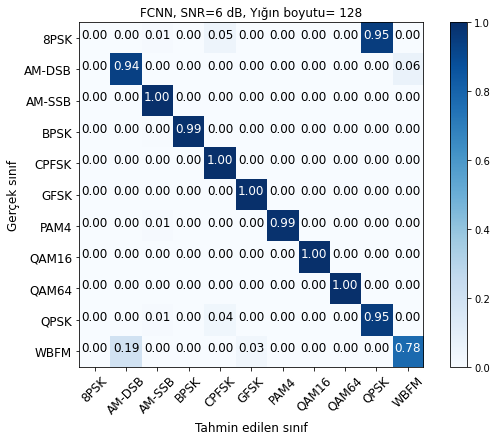

<Figure size 432x288 with 0 Axes>

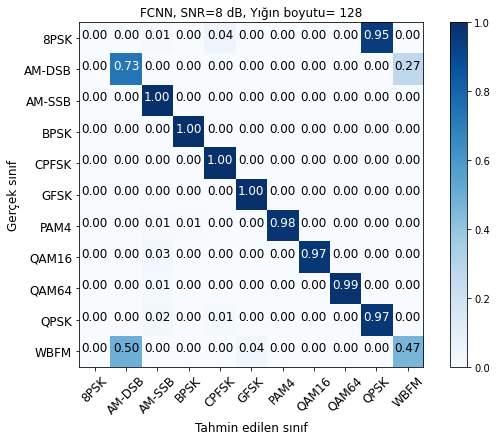

<Figure size 432x288 with 0 Axes>

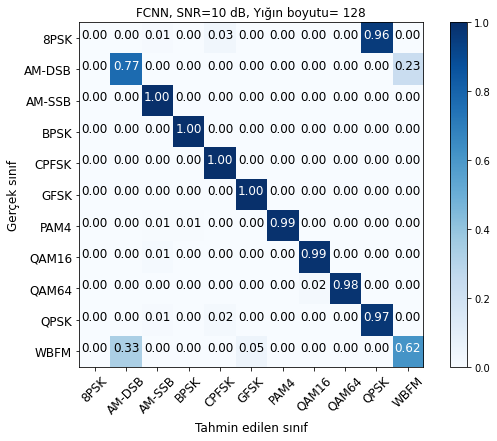

<Figure size 432x288 with 0 Axes>

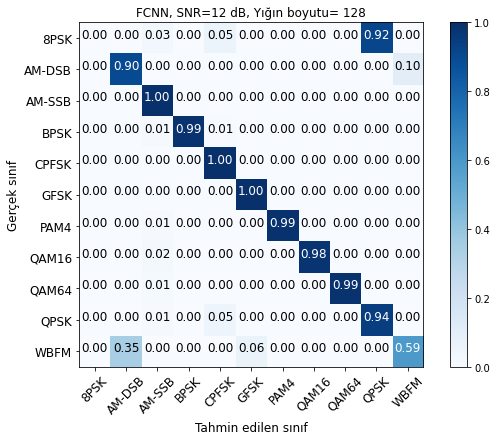

<Figure size 432x288 with 0 Axes>

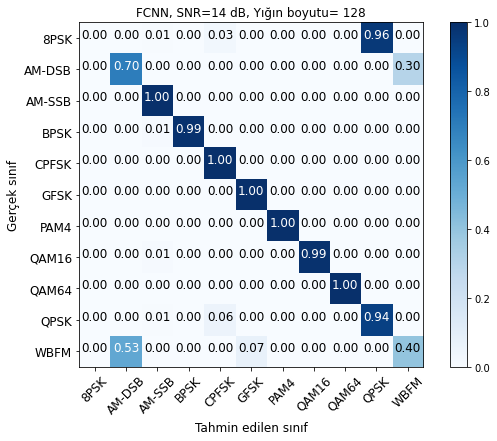

<Figure size 432x288 with 0 Axes>

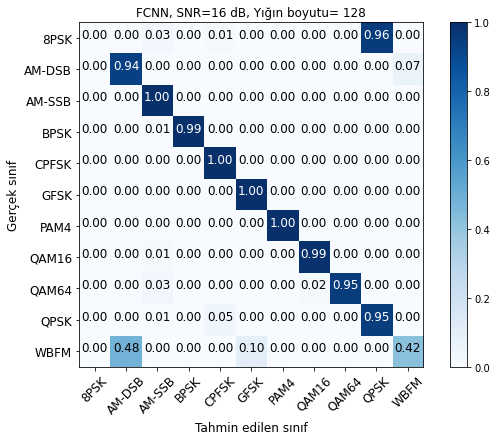

<Figure size 432x288 with 0 Axes>

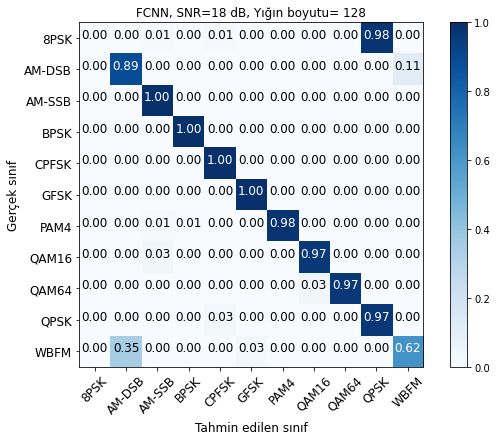

<Figure size 432x288 with 0 Axes>

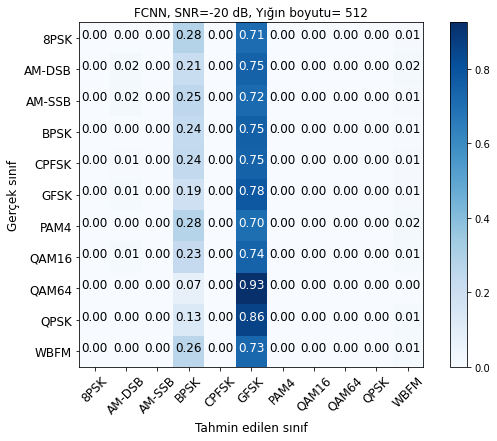

<Figure size 432x288 with 0 Axes>

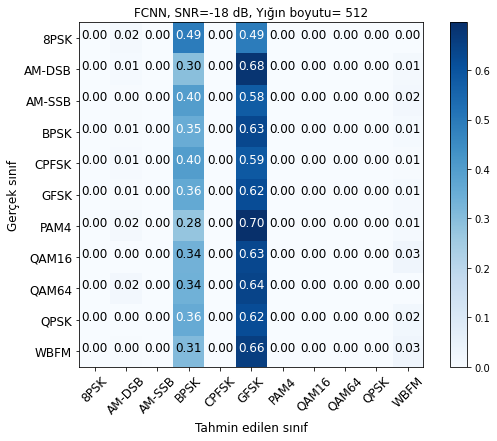

<Figure size 432x288 with 0 Axes>

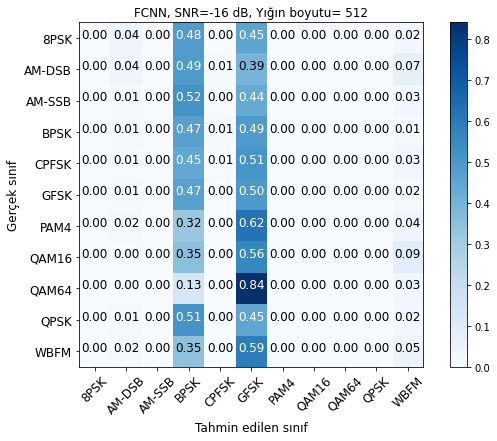

<Figure size 432x288 with 0 Axes>

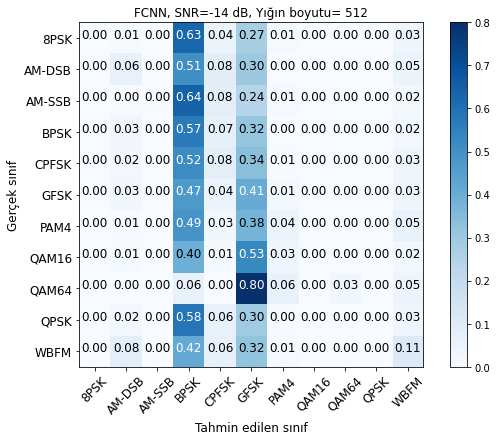

<Figure size 432x288 with 0 Axes>

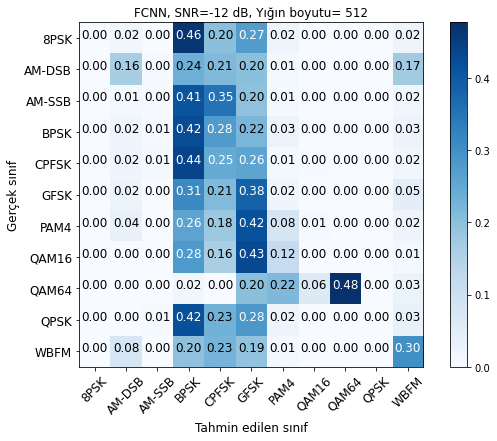

<Figure size 432x288 with 0 Axes>

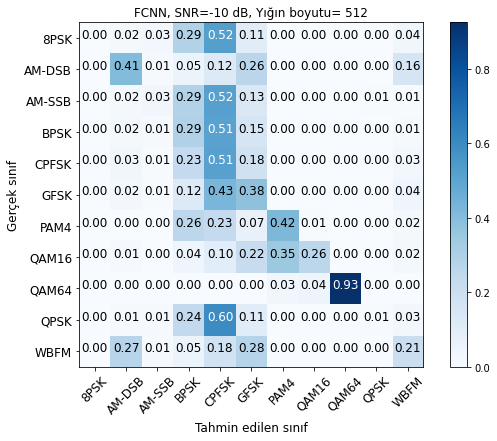

<Figure size 432x288 with 0 Axes>

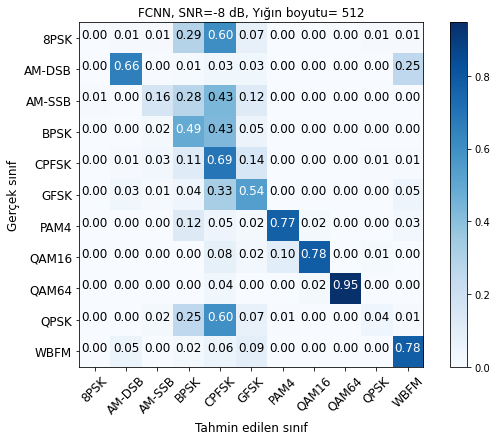

<Figure size 432x288 with 0 Axes>

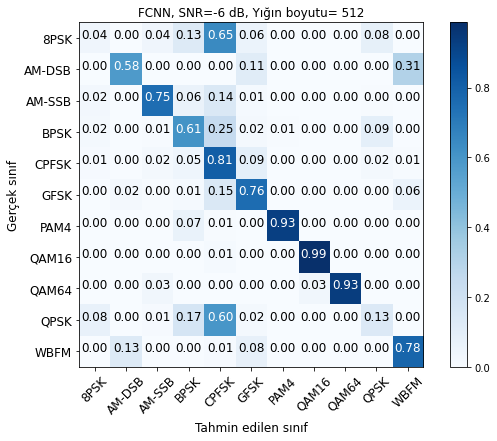

<Figure size 432x288 with 0 Axes>

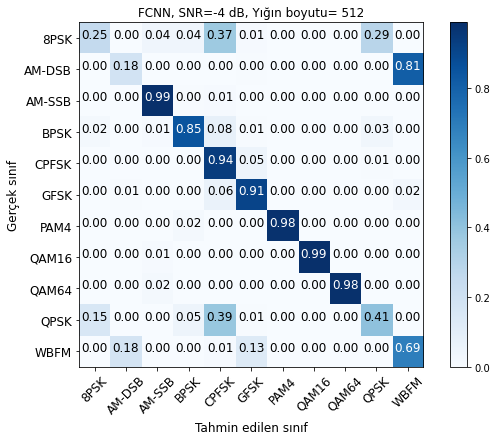

<Figure size 432x288 with 0 Axes>

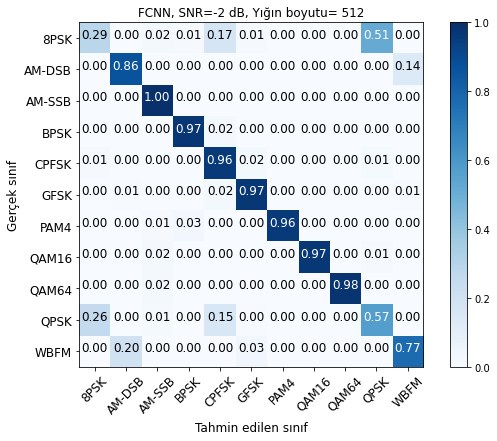

<Figure size 432x288 with 0 Axes>

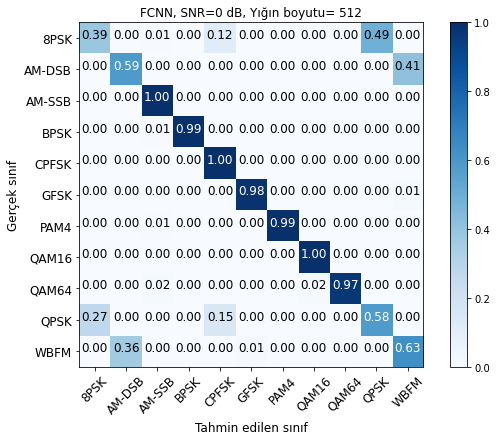

<Figure size 432x288 with 0 Axes>

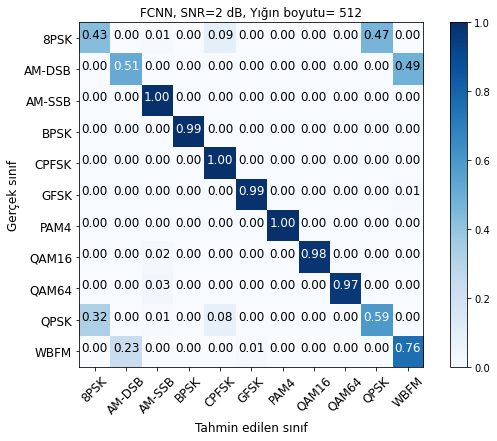

<Figure size 432x288 with 0 Axes>

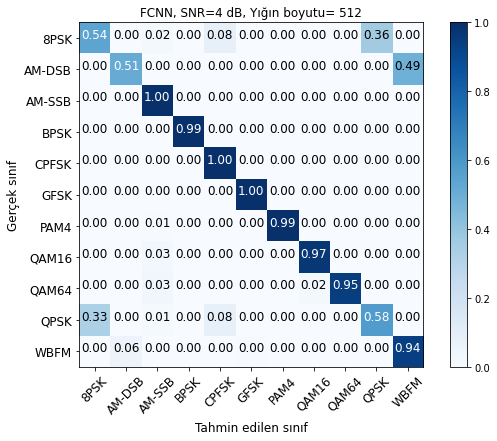

<Figure size 432x288 with 0 Axes>

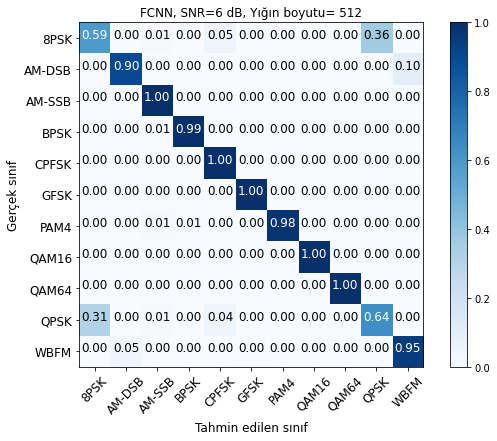

<Figure size 432x288 with 0 Axes>

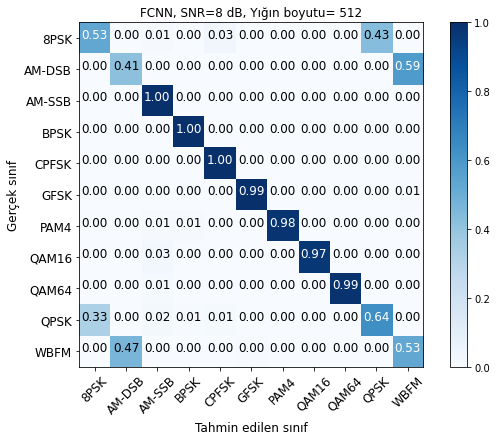

<Figure size 432x288 with 0 Axes>

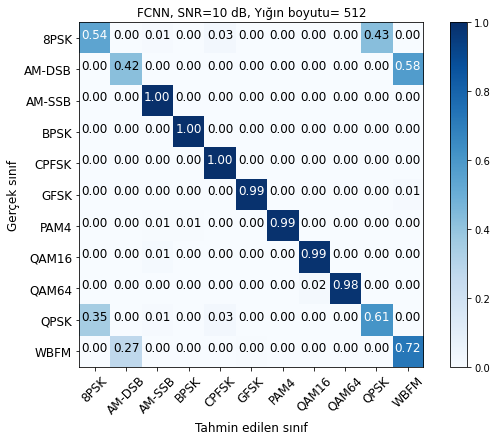

<Figure size 432x288 with 0 Axes>

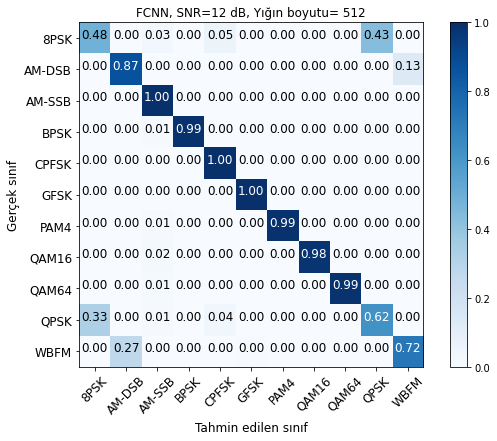

<Figure size 432x288 with 0 Axes>

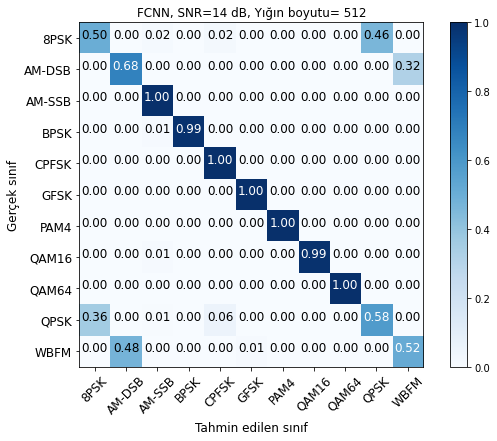

<Figure size 432x288 with 0 Axes>

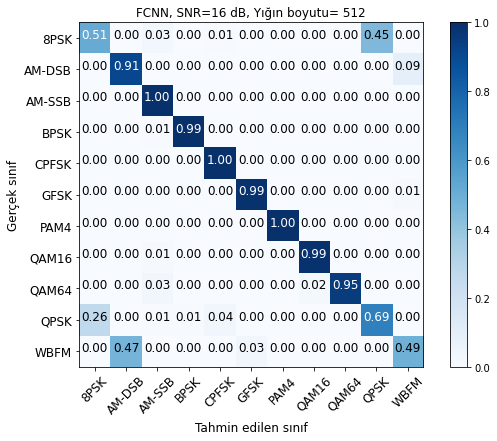

<Figure size 432x288 with 0 Axes>

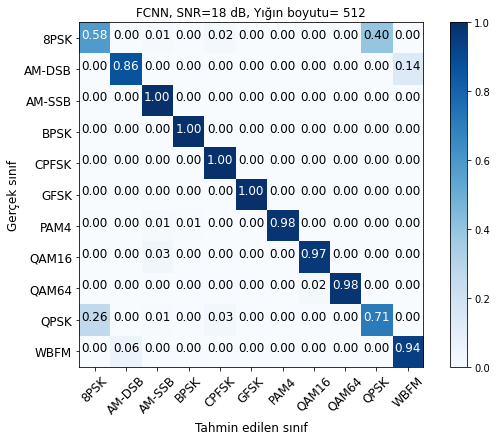

<Figure size 432x288 with 0 Axes>

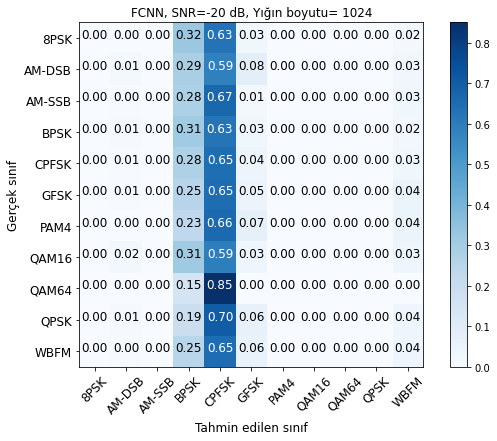

<Figure size 432x288 with 0 Axes>

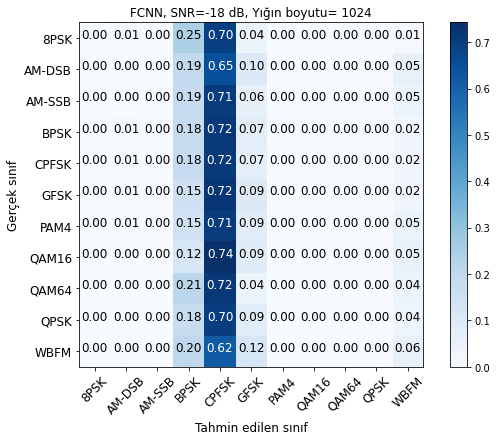

<Figure size 432x288 with 0 Axes>

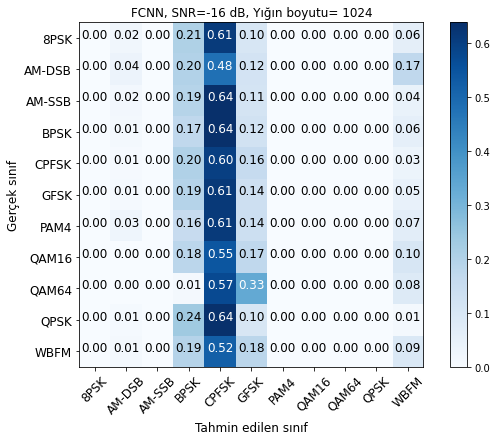

<Figure size 432x288 with 0 Axes>

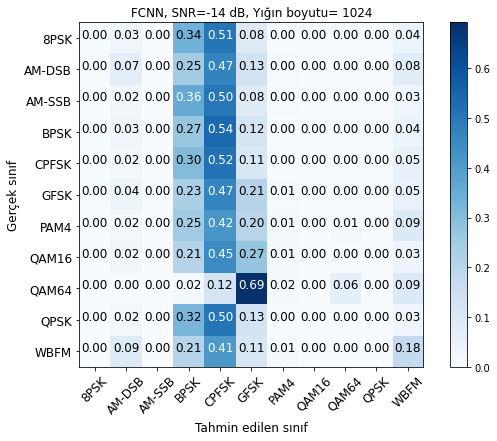

<Figure size 432x288 with 0 Axes>

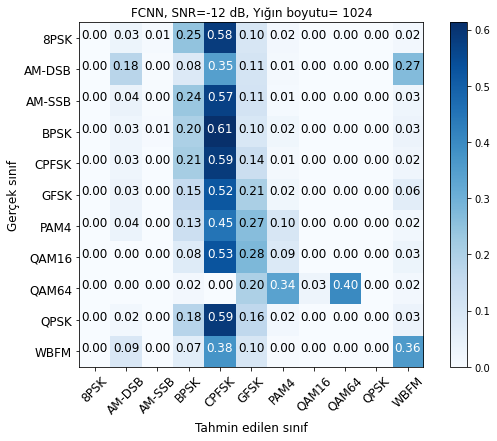

<Figure size 432x288 with 0 Axes>

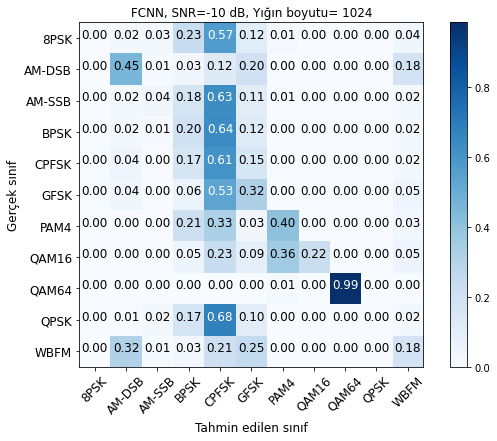

<Figure size 432x288 with 0 Axes>

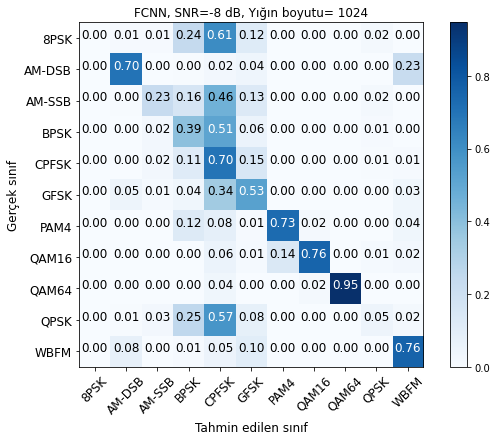

<Figure size 432x288 with 0 Axes>

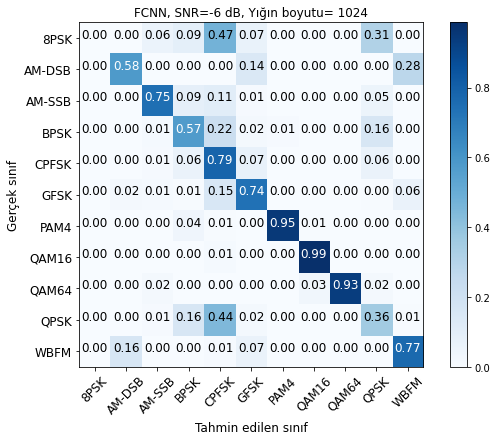

<Figure size 432x288 with 0 Axes>

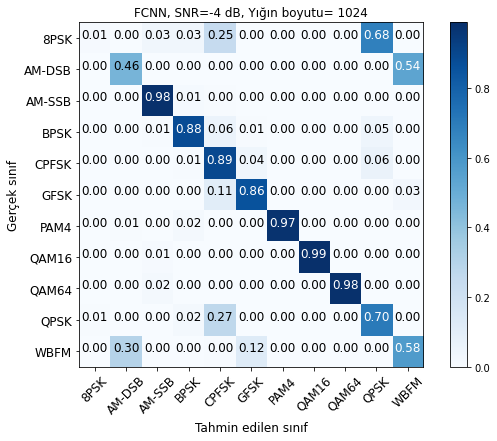

<Figure size 432x288 with 0 Axes>

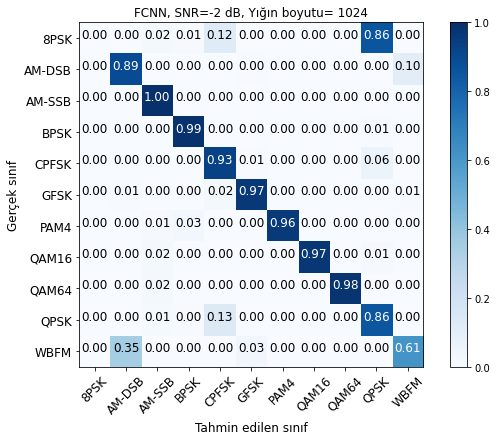

<Figure size 432x288 with 0 Axes>

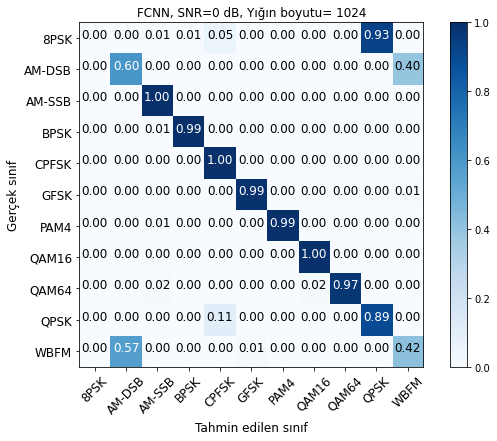

<Figure size 432x288 with 0 Axes>

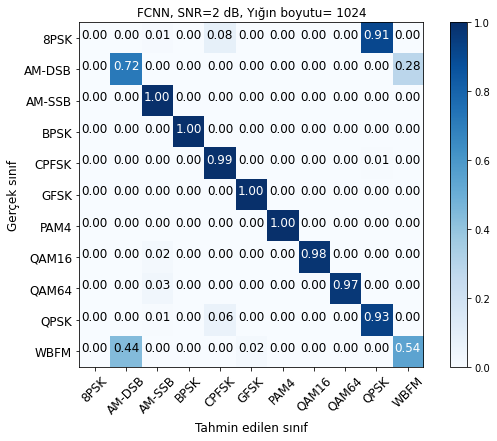

<Figure size 432x288 with 0 Axes>

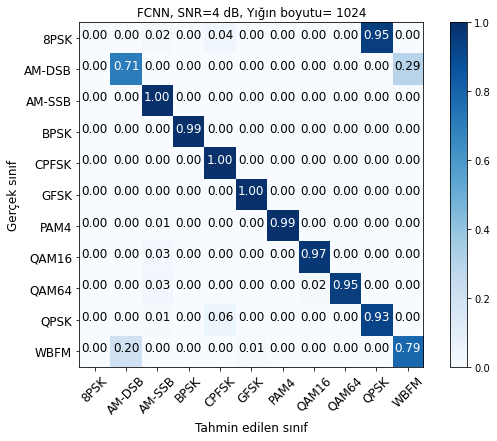

<Figure size 432x288 with 0 Axes>

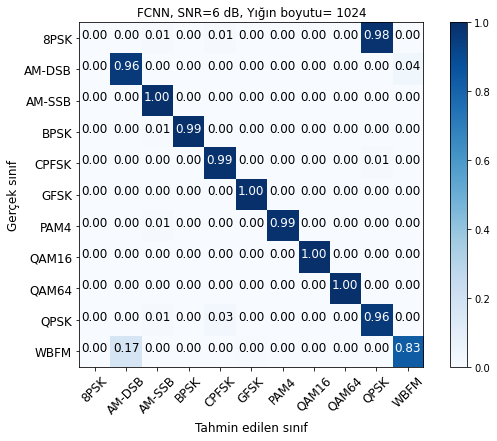

<Figure size 432x288 with 0 Axes>

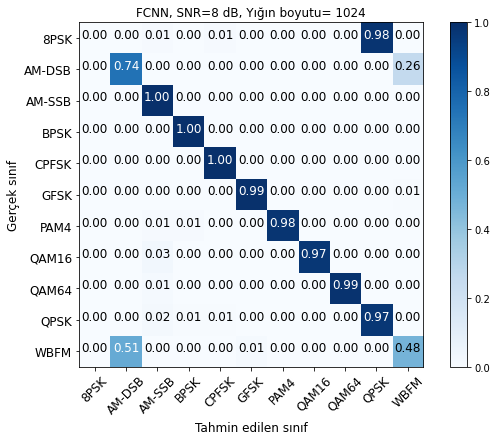

<Figure size 432x288 with 0 Axes>

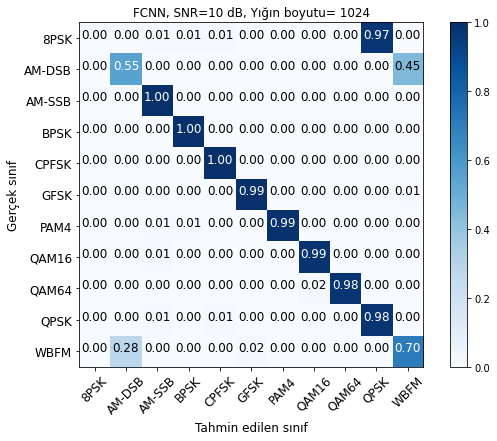

<Figure size 432x288 with 0 Axes>

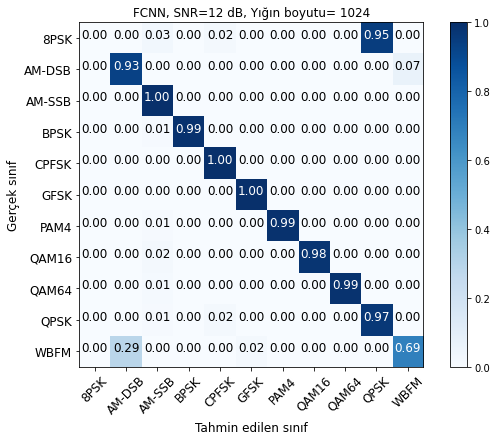

<Figure size 432x288 with 0 Axes>

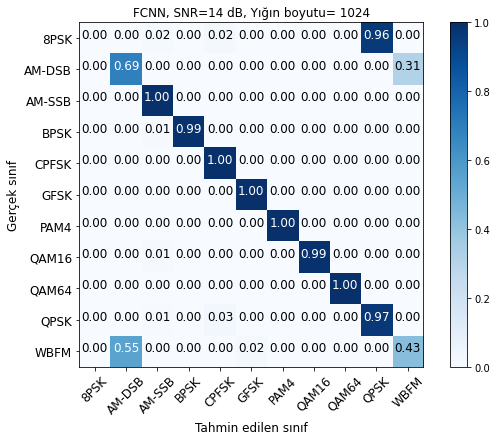

<Figure size 432x288 with 0 Axes>

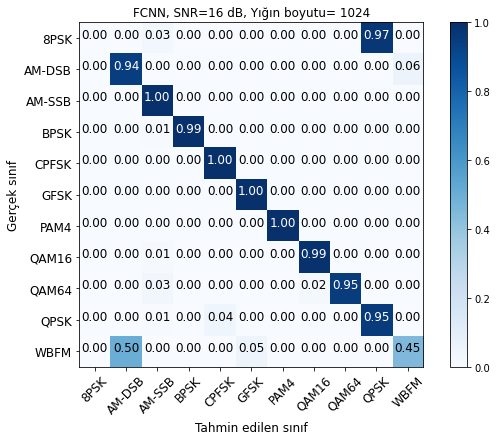

<Figure size 432x288 with 0 Axes>

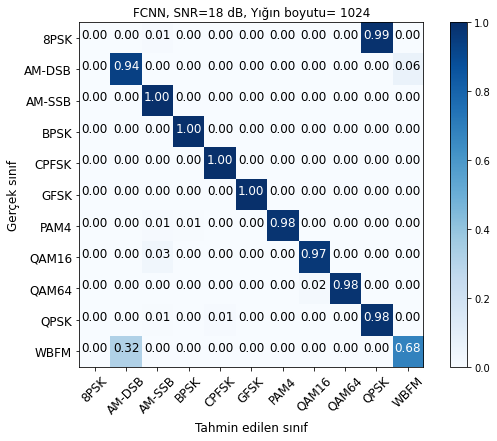

In [ ]:
acc1 = plot_cm_snr(trained_model1, batchsize1)
acc2 = plot_cm_snr(trained_model2, batchsize2) 
acc3 = plot_cm_snr(trained_model3, batchsize3) 
acc4 = plot_cm_snr(trained_model4, batchsize4) 

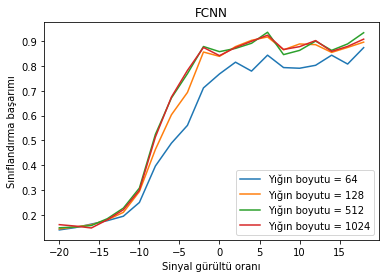

In [ ]:
# Plot accuracy curve
plt.plot(SNRs, list(map(lambda x: acc1[x], SNRs)), label = 'Yığın boyutu = 64')
plt.plot(SNRs, list(map(lambda x: acc2[x], SNRs)), label = 'Yığın boyutu = 128')
plt.plot(SNRs, list(map(lambda x: acc3[x], SNRs)), label = 'Yığın boyutu = 512')
plt.plot(SNRs, list(map(lambda x: acc4[x], SNRs)), label = 'Yığın boyutu = 1024')
plt.title("FCNN")
plt.xlabel("Sinyal gürültü oranı")
plt.ylabel("Sınıflandırma başarımı")
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score


In [ ]:
# Confusion Matrix
print("Yığın boyutu - 64 sonuçları")
y_pred = trained_model1.predict(X_test, batch_size=batchsize1)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 64 sonuçları
roc_auc_score:  0.9181379655523003
mean_absolute_error:  0.10104680411132148
mean_squared_error:  0.04698833939217711
r2_score:  0.4326444069607042


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.12777515, 0.53247664, 0.38647735, 0.52953157,
       0.5419054 , 0.61438263, 0.64721627, 0.66640316, 0.20010422,
       0.37037037])

In [ ]:
# Confusion Matrix
print("Yığın boyutu - 128 sonuçları")
y_pred = trained_model2.predict(X_test, batch_size=batchsize2)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 128 sonuçları
roc_auc_score:  0.9387929250925061
mean_absolute_error:  0.08238292619639541
mean_squared_error:  0.03930379725386066
r2_score:  0.5142517239185985


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.4492206 , 0.59135514, 0.56795132, 0.58818737,
       0.6       , 0.66621438, 0.66702355, 0.71067194, 0.46795206,
       0.35091023])

In [ ]:
# Confusion Matrix
print("Yığın boyutu - 512 sonuçları")
y_pred = trained_model3.predict(X_test, batch_size=batchsize3)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 512 sonuçları
roc_auc_score:  0.9437655188430263
mean_absolute_error:  0.07511047002782743
mean_squared_error:  0.037380961218112935
r2_score:  0.53547981906087


array([0.23169717, 0.44874823, 0.62663551, 0.61392833, 0.6089613 ,
       0.63824117, 0.68656716, 0.68522484, 0.73280632, 0.29233976,
       0.50638209])

In [ ]:
# Confusion Matrix
print("Yığın boyutu - 1024 sonuçları")
y_pred = trained_model4.predict(X_test, batch_size=batchsize4)
print("roc_auc_score: ", roc_auc_score(Y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error: ", mean_absolute_error(Y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("mean_squared_error: ", mean_squared_error(Y_test, y_pred))
print("r2_score: ", r2_score(Y_test, y_pred))
accuracy_score(Y_test, y_pred.round())
precision_score(Y_test, y_pred.round(), average=None)
recall_score(Y_test, y_pred.round(), average=None)

Yığın boyutu - 1024 sonuçları
roc_auc_score:  0.9436706100091956
mean_absolute_error:  0.07506358786042434
mean_squared_error:  0.0373443797210115
r2_score:  0.5355330037447626


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.52479924, 0.62757009, 0.60933063, 0.60285132,
       0.63610926, 0.68276798, 0.67826552, 0.73201581, 0.52058364,
       0.42707679])